# FAKE NEWS DETECTION MODEL

### Loading Dataset from .csv file

The following project was inspired by *kaggle.com*, and the dataset used for modelling was from their website. Our original dataset, *original_news.csv*, contains 4 columns. These columns consist of an ***ID*** number, the ***title*** of the new article, the ***text*** of the whole article and the target ***label*** for modelling purposed. We will proceed with the importing of the appropriate packages.

In [234]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pyplot
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

Next, we shall now load the original dataset into python. The head of the pandas dataset is presented below. 

In [123]:
dataset = pd.read_csv('original_news.csv') #create pandas dataframe using .csv file
display(dataset.head()) #display top 5 entries

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Before we proceed, we must ensure that all duplicates are removes from the dataset. On the *kaggle* website, where I obtained the dataset, the page corresponding to this data contained a brief summary of the whole dataset. Viewing this I discovered that multiple datapoints existed with identical values. In order to avoid the possibility of oversaturating out predictive models with multiple datapoint of identical values, we must remove them. Once this simply bit of data cleaning is finished, we may proceed to explore our data. The number of duplicate data points removed is 29.

In [135]:
dataset = dataset.drop_duplicates(subset = ['title','text']) #remove duplicates if they share the same values for 'title' AND 'text'

## Exploratory Data Analysis

To further expand the search for possible correlations to create a more reliable predictive model for this project, we shall introduce some more metrics for each item in our dataframe. We shall introduce the features, ***title_word_count*** and ***text_word_count***. As these names may suggest, they are simply the number of words present within the ***title*** and ***text*** respectively.

In [136]:
dataset['title_word_count'] = dataset['title'].str.split().apply(len) #from 'title', convert to string, split string to list and apply length to list
dataset['text_word_count'] = dataset['text'].str.split().apply(len) #from 'text', convert to string, split string to list and apply length to list

display(dataset.head())

,Unnamed: 0,title,text,label,title_word_count,text_word_count
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,5,1296
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,9,431
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,15,404
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,9,317


These new metrics that we have evaluated are now prime subjects to perform some basic exploratory data analysis upon them to discover how each data series is distributed across our whole dataset. For now we shall create histograms for each group of data to discover a distribution for each and evaluate their basic properties, such as their mean and variance. 

In [138]:
def mean_and_variance(input_dataset,column_label):
    data = input_dataset[column_label]
    mean = sum(data)/len(data)
    variance = np.var(data)
    print(f'Mean of \'{column_label}\' data: {mean},\n')
    print(f'Variance of \'{column_label}\' data: {variance}.\n')
    return mean, variance

title_word_count_metrics = mean_and_variance(dataset,'title_word_count')
text_word_count_metrics = mean_and_variance(dataset,'text_word_count')

Mean of 'title_word_count' data: 10.495876942594355,

Variance of 'title_word_count' data: 15.879542150413489.

Mean of 'text_word_count' data: 776.3495084046939,

Variance of 'text_word_count' data: 732167.4376282074.



Text(0, 0.5, 'No. of Datapoints')

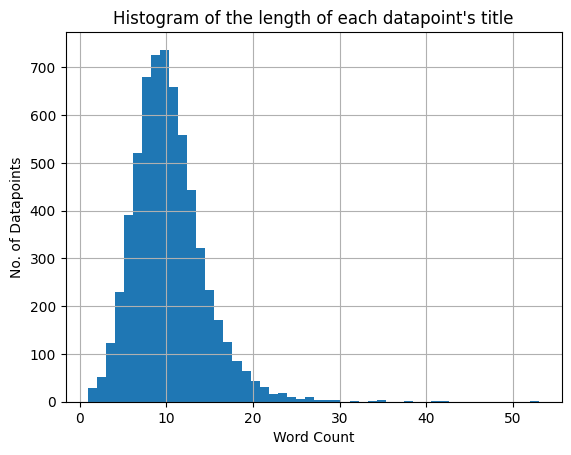

In [139]:
dataset['title_word_count'].hist(bins=50) #histogram of bin number equal to 50 from 'title_word_count' data
pyplot.title('Histogram of the length of each datapoint\'s title') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label

Text(0, 0.5, 'No. of Datapoints')

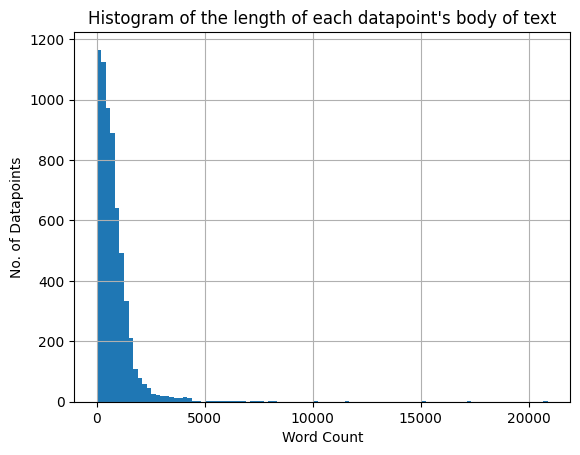

In [140]:
dataset['text_word_count'].hist(bins=100) #histogram of bin number equal to 100 from 'title_word_count' data
pyplot.title('Histogram of the length of each datapoint\'s body of text') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label

The mean and variance of the ***title_word_count*** data seem relatively normal. This is reinforced when observing the histogram of this data. The distribution peaks around the mean, roughly, and the spread of data seems reasonable, if we exclude the fact that our variable cannot be negative in value. However,we start to see irregularities when observing the metrics for the ***text_word_count*** data. The mean again seems relatively standard when compared with the histogram. However, the variance is extremely high. Obervation on the respective histogram revelas that there exists numerious data point where the number of words in the main body of text of the new article exceed 10,000 words! This will naturally overwhelm the variance value with our mean being relatively so small compared. All the datapoints that exceed this 10,000 word count margin are shown below.

In [141]:
display(dataset[dataset['text_word_count'] > 10000]) #show all extreme values for 'text_word_count' length

,Unnamed: 0,title,text,label,title_word_count,text_word_count
536,9618,President Putin Asks US To Stop Provoking Russia,Here is President Putin’s speech at Valdai Put...,FAKE,8,11662
1359,5604,Benny Morris’s Untenable Denial of the Ethnic ...,References The Debate \nIt started when Daniel...,FAKE,10,15199
3436,5765,Re: It Is Now Mathematically Impossible To Pay...,It Is Now Mathematically Impossible To Pay Off...,FAKE,13,17332
3685,8441,Re: America Has Become A Lawless Nation – Hill...,America Has Become A Lawless Nation – Hillary ...,FAKE,15,10090
4733,7910,Re: Why Are So Many People Choosing To Leave T...,Why Are So Many People Choosing To Leave The U...,FAKE,13,20891


From this we can make our first discovery about the dataset. Every data point that exceeds the 10,000 word count is classified as **FAKE**. We can use this observation later whose we have developed our first predictive models to see if they have also observed this trend and used this. An observation like this would work incredibly well in a modelling process such as a *decision tree* model. We could now do something smilar with the ***title_word_count*** now to see if any patterns like this can be discovered. Let us ask if data points with ***title_word_count*** values exceeding 30 are typically classified as **FAKE**.

In [142]:
display(dataset[dataset['title_word_count'] >= 30])

,Unnamed: 0,title,text,label,title_word_count,text_word_count
261,7892,Comment on Breaking: CDC Blocks Testimony of T...,Have you heard of Dr. William Thompson? If y...,FAKE,35,919
436,6329,Muslims regularly use “Inshallah” (“God Willin...,BNI Store Nov 5 2016 Muslims regularly use “In...,FAKE,30,665
1041,5939,Comment on The Science is “Overwhelming At Thi...,This ordinance is a big step forwards by cre...,FAKE,34,2513
1073,7560,Comment on ‘Voting Is Rigged & Used To Pacify ...,Share on Facebook Share on Twitter “This is th...,FAKE,38,1360
1208,5420,12 and 63-minute videos: Donald Trump connects...,"Posted on November 7, 2016 by Carl Herman \nJo...",FAKE,35,1421
1562,7769,Comment on Canadian Air Force Pilot Snaps A Pi...,Share on Facebook Share on Twitter “If it does...,FAKE,32,1077
1580,6031,Comment on Hillary Clinton failed to disclose ...,DCG | 2 Comments \nRules are for little peop...,FAKE,42,730
1663,9064,"Life: If You Love Enamel Pins, You’ll Love Thi...","Email If you can’t get enough enamel pins, the...",FAKE,53,375
2763,8341,Comment on Shocking Insinuation About Carl Sag...,Share on Facebook Share on Twitter A few years...,FAKE,32,3009
3607,6321,Queen Elizabeth II owns every dolphin in Brita...,Email \nQueen Elizabeth II is not like you and...,FAKE,30,2887


As we can see, all 15 data points that have title lengths that exceed or are equal to 30 words are all classified as **FAKE**. This can also be used to determine the success of any models that we evaluate in the future. These finds give us promise that correlations exist within the dataset to allow us to create a reliable prodictive model. Now that we have these findings, we are presented with another question that must be asked; Is there a need for the ***title*** and ***text*** data now? Have we extracted all infomation that may prove usful for our model? No. There still exists relavent information within these string data values. For instance, two of the joint most numerius data values associated with the *title* column are 'OnPolitics | 's politics blog' and 'Michael Moore Owes Me $4.99'. When we display all their respective datapoint out we observe that even though they have the same amount of ***title_word_count*** value, their ***label*** values are mutual exclusive from one another.

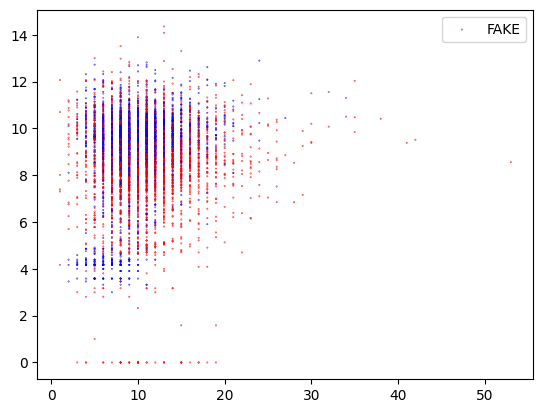

In [231]:
colour = {'REAL': 'blue', 'FAKE': 'red'}
pyplot.scatter(dataset['title_word_count'],np.log2(dataset['text_word_count']+1), c = dataset['label'].map(colour), s=0.4, marker='.')
pyplot.legend(['FAKE','REAL'])

As we can see from the scatter plot above, some logic is present regarding determining **FAKE** and **REAL** news. Outlier datapoints where ***title_Word_count*** and ***text_word_count*** is either too high or too low are typically labels as **FAKE**. However, a closed form structural review for all datapoints still eludes us. **REAL** and **FAKE** datapoints cluster around eachother, so we can conclude that evaluating just the word count for the tile and the main text of each news article is not enough to reliable predict when the datapoint is within this cluster. So we shall now implement a new metric for our data. We shall implement a sentiment analysis model to out datapoints to get a metric of how possitive or negative an article is. Perhaps a negative article is more likely to be fake than real.

In [243]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #tokenizer converts text into series of numerical values
sentiment_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #load pretrained sentiment model 

def sentiment_score(text): #define function to get sentiment score from model
    tokens = tokenizer.encode(text,return_tensors='pt') #tokenizer encodes given text into numerical values, returned in a pytorch tensor
    output = sentiment_model(tokens) #feed tokenizer data into model
    return int(torch.argmax(output.logits))+1 #convert output array into score

dataset['title_sentiment_score'] = dataset['title'].apply(lambda x: sentiment_score(x)) #
dataset['text_sentiment_score'] = dataset['text'].apply(lambda x: sentiment_score(x[:512])) #sentiment model is limited with how many tokens it can process at one time, specifically it is 512, so using only 512st words in text for evaluating

display(dataset.head())

This sentiment model scores using a scale from 1 to 5, with 1 corresponding with a negative sentiment and 5 being a positive sentiment. However, we have had to make a concession regarding the ***text*** data when evaluating it's sentiment score. Due to limitations with the sentiment model we are using, only the first 512 tokens of text can be used to assess the whole text's sentiment score. This may lead to sentiment scores not reflecting the true score of a body of text, but typically the beginning of an article sets a specific tone for the remainder of the text. This could be in the for or a intorduction which goes over what will be discussed or if its simply stating the purpose of the text. So for our analysis, we will have to assume the following: **The sentiment score for the text for each datapoint remains constant through the text itself**. We will perform this sentiment analysis on both the ***title*** and ***text***. The motivation behind this is that correlation may exist between the ***label*** and the difference in sentiment score between the title of an article and the main body of text, as a form of *click-baiting*. Furthermore, we want to see if our hypothesis is true that negatively sentimented articles are more likely to be ***FAKE***. We could also assess whether extreme sendiment scores on either side of neutral (1 or 5) correlate with labelling articles fake or not, to play to a specific audiance's emotions about a specific issue to get more view.

In [ ]:
dataset['title_sentiment_score'].hist(bins=1)
pyplot.title('Distribution of title sentiment score')
pyplot.xlabel('Sentiment Score')
pyplot.ylabel('Frequency of score')